<h1>This notebook contains code to plot mean NDVI time-series<h1>

<h2>STEP 1<h2>
    <blockquote>installing necessary libraries and dependancies

In [1]:
#Install necessary libraries
#uncomment the line below to install the necessary libraries
#!pip install geopandas matplotlib rasterio numpy pandas pathlib

# Import the necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from pathlib import Path

<h2>STEP 2<h2>
<blockquote>We need to define fuctions to (a) load and display shapefiles we will use, (b)check and transform coordinate reference system if there is any mismatch (c) extract ndvi values

In [2]:
def load_and_display_shapefile(shapefile_path):
    try:
        shapes = gpd.read_file(shapefile_path)
        if not shapes.empty:
            print("Shapefile loaded successfully. Displaying contents:")
            print(shapes)
            # Plot the shapefile
            shapes.plot()
            plt.show()
        else:
            print("Shapefile loaded but contains no data.")
        return shapes
    except Exception as e:
        print(f"Failed to load shapefile: {e}")
        return None

In [3]:
def check_and_transform_crs(shapes, raster_crs):
    if shapes.crs != raster_crs:
        print(f"Transforming shapefile CRS from {shapes.crs} to {raster_crs}")
        shapes = shapes.to_crs(raster_crs)
    return shapes

In [4]:
def extract_polygonwise_ndvi(raster_files, shapes):
    data_cube = {}
    for raster_file in raster_files:
        with rasterio.open(raster_file) as src:
            raster_crs = src.crs
            shapes = check_and_transform_crs(shapes, raster_crs)

            raster_name = raster_file.stem
            polygon_values = []
            for geom in shapes.geometry:
                try:
                    # Mask the raster with the polygon
                    out_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
                    out_image = out_image[0]  # Assuming single band raster
                    
                    # Extract valid values
                    valid_values = out_image[out_image > 0]
                    
                    # Calculate mean coherence value within the polygon
                    if valid_values.size > 0:
                        mean_value = valid_values.mean()  # Ignore zero values if any
                    else:
                        mean_value = np.nan
                    polygon_values.append(mean_value)
                except Exception as e:
                    print(f"Error processing polygon in {raster_name}: {e}")
                    polygon_values.append(np.nan)
            
            # Store the values in the data cube with raster name as the key
            data_cube[raster_name] = polygon_values
    
    return data_cube

<h2>Define the path to shapefile, list the raster files containing NDVI data in tif format<h2>
    <blockquote>which is obtained using GEE using the code in the repo

In [5]:
# Define the path to the shapefile
#add the path where it is written "Path.home() / "PGD_Project" / "individual_plots_7_combined" / "final_7_plots.shp""
shapefile_path = Path.home() / "PGD_Project" / "individual_plots_7_combined" / "final_7_plots.shp"

In [6]:
# List of raster files
raster_files = [ Path.home() / "PGD_Project" / "ndvi" / fname for fname in [
    "2023-01-24.tif",
    "2023-02-08.tif",
    "2023-02-13.tif",
    "2023-03-05.tif",
    "2023-05-19.tif",
    "2023-05-29.tif",
    "2023-06-08.tif",
    "2023-06-13.tif",
    "2023-07-03.tif",
    "2023-07-23.tif",
    "2023-08-07.tif",
    "2023-08-17.tif",
    "2023-09-01.tif",
    "2023-09-06.tif",
    "2023-10-06.tif",
    "2023-10-11.tif",
    "2023-10-26.tif",
    "2023-11-15.tif",
]]

Shapefile loaded successfully. Displaying contents:
  Name descriptio timestamp begin   end altitudeMo  tessellate  extrude  \
0   P1       None      None  None  None       None           1        0   
1   P2       None      None  None  None       None           1        0   
2   P3       None      None  None  None       None           1        0   
3   P4       None      None  None  None       None           1        0   
4   P5       None      None  None  None       None           1        0   
5   P6       None      None  None  None       None           1        0   
6   P7       None      None  None  None       None           1        0   

   visibility drawOrder  icon  \
0          -1      None  None   
1          -1      None  None   
2          -1      None  None   
3          -1      None  None   
4          -1      None  None   
5          -1      None  None   
6          -1      None  None   

                                            geometry  
0  POLYGON Z ((78.12805 30.

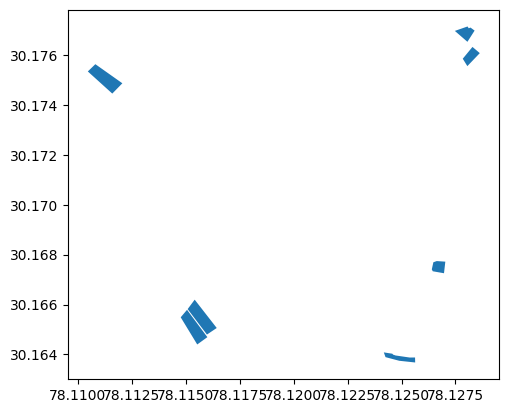

In [7]:
# Load and display the shapefile
shapes = load_and_display_shapefile(shapefile_path)

In [8]:
# Extract polygon-wise coherence values and store them in a data cube
data_cube = extract_polygonwise_ndvi(raster_files, shapes)

Transforming shapefile CRS from epsg:4326 to EPSG:32643
Transforming shapefile CRS from PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]] to EPSG:32644
Transforming shapefile CRS from PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHOR

In [9]:
# Convert the data cube to a DataFrame for easier analysis and visualization
df = pd.DataFrame(data_cube, index=[f'Polygon_{i}' for i in range(len(shapes))])

In [10]:
# Display the DataFrame
print(df)

           2023-01-24  2023-02-08  2023-02-13  2023-03-05  2023-05-19  \
Polygon_0    0.474151    0.302548    0.368197    0.253316    0.559981   
Polygon_1    0.513134    0.445469    0.573280    0.579682    0.576523   
Polygon_2    0.648930    0.382628    0.509766    0.437635    0.607609   
Polygon_3    0.605794    0.359738    0.403870    0.302955    0.545787   
Polygon_4    0.652521    0.379168    0.299302    0.221617    0.458577   
Polygon_5    0.461775    0.243101    0.242219    0.232322    0.489547   
Polygon_6    0.508210    0.386634    0.309891    0.196857    0.520734   

           2023-05-29  2023-06-08  2023-06-13  2023-07-03  2023-07-23  \
Polygon_0    0.453253    0.674901    0.662784    0.692995    0.748365   
Polygon_1    0.432188    0.636649    0.656787    0.683322    0.766742   
Polygon_2    0.477348    0.648269    0.662947    0.712172    0.733286   
Polygon_3    0.462339    0.584567    0.585444    0.684405    0.660205   
Polygon_4    0.419549    0.571544    0.587101    0

In [11]:
# Optionally, save the DataFrame to a CSV file, uncomment the below line of code for the same
#df.to_csv(Path.home() / "PGD_Project" / "ndvi_values_P7.csv", index=True)

<h3>Plot the Data

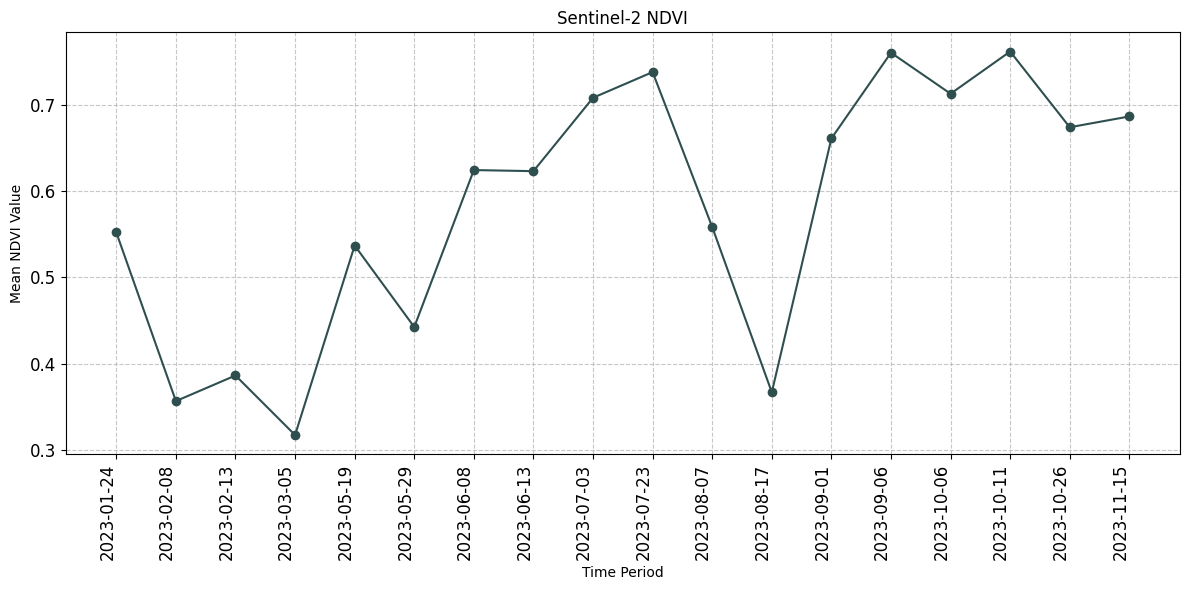

In [12]:
# Read the CSV data
#df = pd.read_csv(Path.home() / "PGD_Project" / "ndvi_values1.csv", index_col=0)

# Calculate the mean of each column, excluding NaN values
mean_values = df.mean(skipna=True)

# Create a list of dates from the column names
dates = mean_values.index.tolist()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(dates, mean_values.values, marker='o',color='darkslategrey')
plt.title('Sentinel-2 NDVI')
plt.xlabel('Time Period')
plt.ylabel('Mean NDVI Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=90, ha='right', fontsize = 12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()